# Pipeline

## 0. **BlocksNet** Installation

Import `geopandas` and set a local coordinate reference system (in EPSG format). Local CRS also can be determined by `estimate_utm_crs()` method of certain `GeoDataFrame`.

In [1]:
import geopandas as gpd
import os

data_path = './../tests/data/'
local_crs = 32637

## 1. Generating a layer of city blocks

Import `BlocksGenerator` class from the library.

In [2]:
from blocksnet import BlocksGenerator

Read `parquet`/`geojson` files with the geometries needed for the generator. One can retrieve the geometries themselve from OSM by the tags provided in `BlocksGenerator` description. Reproject the geometries to local coordinate reference system.

In [3]:
boundaries = gpd.read_parquet(os.path.join(data_path, 'boundaries.parquet')).to_crs(local_crs)
water = gpd.read_parquet(os.path.join(data_path, 'water.parquet')).to_crs(local_crs)
roads = gpd.read_parquet(os.path.join(data_path, 'roads.parquet')).to_crs(local_crs)
railways = gpd.read_parquet(os.path.join(data_path, 'railways.parquet')).to_crs(local_crs)

Initialize `BlocksGenerator` with loaded geometries. Then call `run` method to get a `GeoDataFrame` with block geometries.

In [4]:
bg = BlocksGenerator(
  boundaries=boundaries,
  water=water,
  roads=roads,
  railways=railways
)
blocks = bg.run()

2024-09-25 18:47:18.880 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:99 - Check boundaries schema
2024-09-25 18:47:18.909 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:103 - Check roads schema
2024-09-25 18:47:18.922 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:109 - Check railways schema
2024-09-25 18:47:18.931 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:115 - Check water schema
2024-09-25 18:47:18.939 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:124 - Exclude water objects
2024-09-25 18:47:18.988 | INFO     | blocksnet.preprocessing.blocks_generator:run:161 - Generating blocks
2024-09-25 18:47:19.003 | INFO     | blocksnet.preprocessing.blocks_generator:run:170 - Setting up enclosures
2024-09-25 18:47:19.166 | INFO     | blocksnet.preprocessing.blocks_generator:run:174 - Filling holes
2024-09-25 18:47:19.231 | INFO     | blocksnet.preprocessing.blocks_generator:run:178 - Dropping overlapping blo

In [5]:
blocks

,geometry
0,"POLYGON ((550762.290 6565038.844, 550768.857 6..."
1,"POLYGON ((550768.857 6565033.563, 550762.290 6..."
2,"POLYGON ((544937.479 6564706.592, 544935.619 6..."
3,"POLYGON ((544806.647 6565359.291, 544814.358 6..."
4,"POLYGON ((544793.346 6565395.228, 544800.150 6..."
...,...
732,"POLYGON ((550330.064 6563176.320, 550349.264 6..."
733,"POLYGON ((546106.838 6566506.429, 546183.774 6..."
734,"POLYGON ((552977.299 6562202.373, 553051.882 6..."
735,"POLYGON ((556605.841 6559581.667, 555984.050 6..."


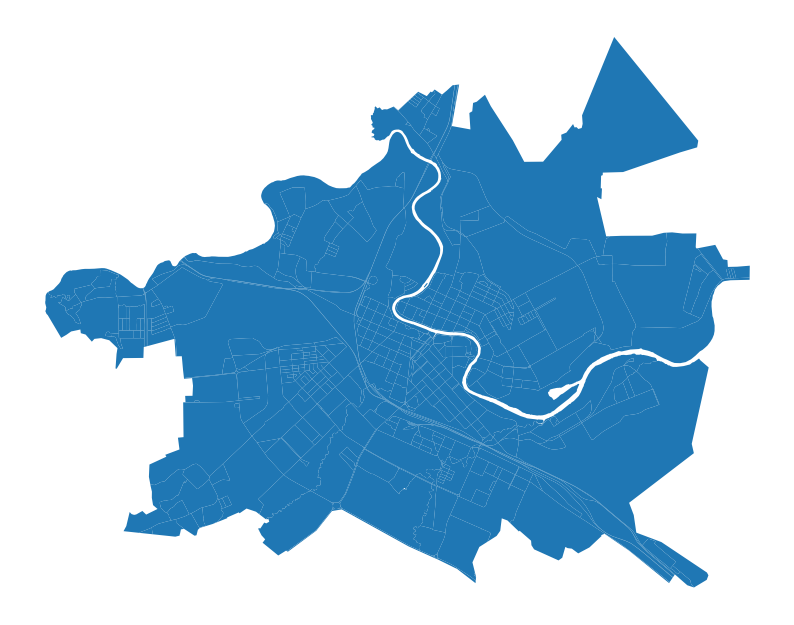

In [6]:
blocks.plot(figsize=(10,10)).set_axis_off()

The resulting blocks can be saved to a file.

In [7]:
blocks.to_file('blocks.geojson')

## 2. Generating an intermodal graph

At this stage, you have to generate an **intermodal graph** by passing the blocks `GeoDataFrame` to `AccessibilityProcessor`.

In [8]:
from blocksnet import AccessibilityProcessor

ap = AccessibilityProcessor(blocks=blocks)
intermodal_graph = ap.get_intermodal_graph()

Parsing pt routes:   0%|          | 0/66 [00:00<?, ?it/s]

Calculating the weights of the walk graph:   0%|          | 0/55802 [00:00<?, ?it/s]

Vizualization of the resulting intermodal graph.

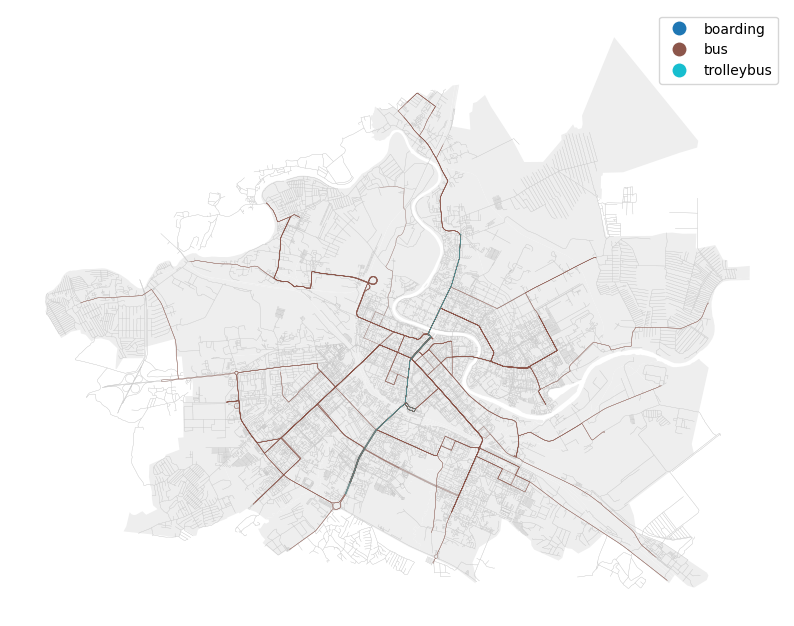

In [9]:
ap.plot(blocks, intermodal_graph)

Saving the graph as a ```geojson``` file

In [10]:
import osmnx as ox
nodes, edges = ox.graph_to_gdfs(intermodal_graph)
edges
nodes.to_file('graph_nodes.geojson')
edges[['geometry', 'type', 'route', 'length_meter', 'time_min']].to_file('graph_edges.geojson')

## 3. Calculating an accessibility matrix

Now, you can calculate an accessibility matrix using the **blocks** layer and **intermodal graph** acquired on the previous stages. This matrix is obtained by finding the shortest travel time between each pair of blocks in the intermodal graph.

In [11]:
accessibility_matrix = ap.get_accessibility_matrix(graph=intermodal_graph)

Output of the obtained accessibility matrix. Each cell `[i,j]` represents the shortest travel time between block `i` and block `j`. The matrix doesn't take into account created demand and traffic.

In [12]:
accessibility_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,727,728,729,730,731,732,733,734,735,736
0,0.000000,4.195312,50.90625,36.781250,31.453125,40.15625,32.281250,33.437500,33.218750,35.125000,...,27.328125,23.65625,23.671875,14.171875,15.398438,19.71875,26.4375,26.43750,40.68750,18.609375
1,4.675781,0.000000,53.53125,39.406250,34.062500,42.78125,34.937500,36.093750,35.843750,37.750000,...,26.296875,22.62500,22.515625,13.007812,14.234375,18.56250,29.0625,25.96875,42.09375,19.968750
2,44.937500,46.437500,0.00000,41.500000,36.156250,53.12500,37.000000,38.156250,37.937500,39.812500,...,62.125000,58.46875,59.781250,50.281250,51.343750,51.78125,65.8125,63.28125,78.93750,56.875000
3,38.687500,40.187500,43.00000,0.000000,5.324219,23.53125,6.902344,8.062500,8.359375,10.242188,...,55.000000,51.34375,52.843750,44.031250,45.062500,44.65625,39.8125,57.03125,72.68750,50.593750
4,33.375000,34.843750,37.68750,5.324219,0.000000,18.21875,1.579102,2.736328,3.035156,4.921875,...,49.687500,46.03125,47.531250,38.687500,39.750000,39.31250,34.5000,51.71875,67.37500,45.281250


Optionally, save the accessibility matrix as a file.

In [13]:
accessibility_matrix.to_pickle('accessibility_matrix.pickle')

## 4. City model initialization

Now with the resulting **matrix** and **blocks layer** we can initialize a city model.

In [14]:
from blocksnet import City

blocks['land_use'] = None

vologda = City(
  blocks=blocks,
  acc_mx=accessibility_matrix,
)

With `print` you can get information about:
- local coordinate reference system;
- the number of blocks in a city;
- number of service types defined in the city (by default) types of city services (by default) and number of service types already loaded in the model;
- number of buildings loaded in the model;
- number of services loaded in the model.

In [15]:
print(vologda)

CRS : EPSG:32637
Blocks : 737
Service types : 0/66
Buildings : 0
Services : 0



With this model, you can already perform basic analysis of urban environment. However, for more advanced analysis, information about existing services and buildings should be updated. 

At first, one should update city buildings layer, for some of the services will update the information about the capacity based on whether located or not inside of the building. Buildings spatial layer should contain the following columns:

- **index** : `int` - unique building id
- **geometry** : `Polygon` | MultiPolygon
- **build_floor_area** : `float` >= 0
- **living_area** : `float` >= 0
- **non_living_area** : `float` >= 0
- **footprint_area** : `float` >= 0
- **number_of_floors** : `int` >= 1
- **population** : `int` >= 0

In [16]:
buildings = gpd.read_parquet(os.path.join(data_path, 'buildings.parquet')).to_crs(local_crs)
buildings.head()

,geometry,number_of_floors,is_living,footprint_area,build_floor_area,living_area,population
0,"POLYGON ((551734.377 6561005.520, 551753.023 6...",2.0,False,3051.403190,6102.806380,0.000000,0
1,"POLYGON ((551242.888 6561217.885, 551255.024 6...",1.0,False,947.828484,947.828484,0.000000,0
2,"POLYGON ((551677.852 6560979.128, 551735.071 6...",5.0,True,643.583783,3217.918916,2574.335133,117
3,"POLYGON ((551600.420 6561013.594, 551657.042 6...",1.0,True,682.649464,682.649464,0.000000,0
4,"POLYGON ((550484.802 6569857.123, 550472.896 6...",1.0,False,230.815777,230.815777,0.000000,0


Buildings that did not intersect any blocks will be returned from `update_buildings()` method.

In [17]:
vologda.update_buildings(buildings)

2024-09-25 18:48:10.872 | INFO     | blocksnet.models.city:update_buildings:1237 - Removing existing blocks from the model
2024-09-25 18:48:10.877 | INFO     | blocksnet.models.city:update_buildings:1241 - Joining buildings and blocks
2024-09-25 18:48:14.410 | WARNING  | blocksnet.models.city:update_buildings:1253 - 2 buildings did not intersect any block
Update blocks buildings: 100%|██████████| 471/471 [00:03<00:00, 148.27it/s]


,geometry,number_of_floors,is_living,footprint_area,build_floor_area,living_area,population
9781,"POLYGON ((551681.237 6564001.208, 551661.600 6...",1.0,False,504.758281,504.758281,0.0,0
16467,"POLYGON ((551668.426 6563984.529, 551678.221 6...",1.0,False,463.814782,463.814782,0.0,0


After the buildings spatial layer update, one must update the information about city services. In this example, we only update the information about schools and kindergartens, that are defined in the model by default by `school` and `kindergarten` unique keys.

In [18]:
vologda['school']

ServiceType(code='3.5.1', name='school', accessibility=15, demand=120, land_use=[<LandUse.RESIDENTIAL: 'residential'>, <LandUse.BUSINESS: 'business'>], bricks=[ServiceBrick(capacity=250, area=3200.0, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=300, area=4000.0, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=600, area=8200.0, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=1100, area=13000.0, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=250, area=2200.0, is_integrated=True, parking_area=200.0), ServiceBrick(capacity=300, area=3600.0, is_integrated=True, parking_area=300.0), ServiceBrick(capacity=600, area=7100.0, is_integrated=True, parking_area=600.0)])

In [19]:
school = gpd.read_parquet(os.path.join(data_path, 'school.parquet')).to_crs(local_crs)
kindergarten = gpd.read_parquet(os.path.join(data_path, 'kindergarten.parquet')).to_crs(local_crs)

vologda.update_services('school', school)
vologda.update_services('kindergarten', kindergarten)

As we don't have an information about `LandUse`, we can try to predict it based on existing services in the model. But we need more information about located services than in this example.

In [20]:
from blocksnet import LandUsePrediction

lup = LandUsePrediction(city_model=vologda)
lu_blocks = lup.calculate()
lu_blocks.head()

100%|██████████| 737/737 [00:02<00:00, 321.16it/s]


,geometry,land_use
id,,
0,"POLYGON ((550762.290 6565038.844, 550768.857 6...",None
1,"POLYGON ((550768.857 6565033.563, 550762.290 6...",None
2,"POLYGON ((544937.479 6564706.592, 544935.619 6...",RESIDENTIAL
3,"POLYGON ((544806.647 6565359.291, 544814.358 6...",None
4,"POLYGON ((544793.346 6565395.228, 544800.150 6...",None


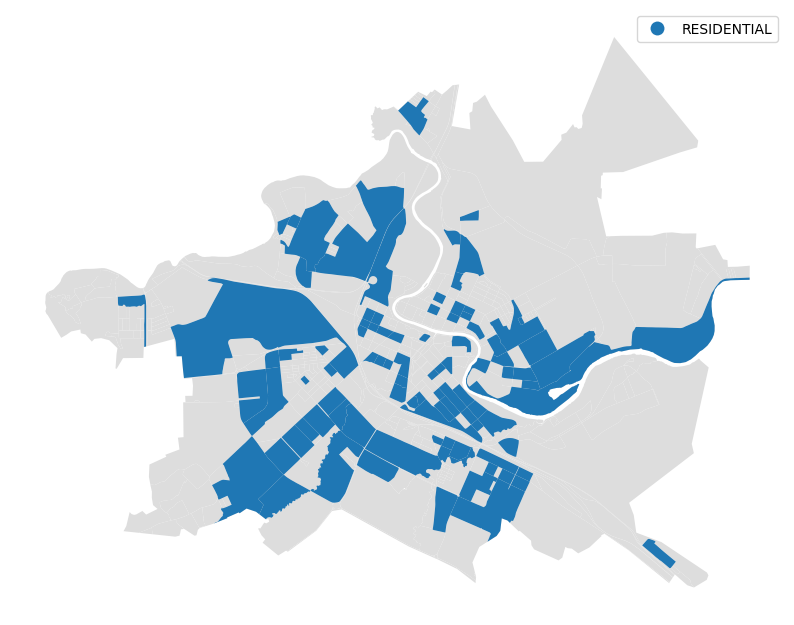

In [21]:
lup.plot(lu_blocks)

Update the information about `LandUse` in the model.

In [22]:
vologda.update_land_use(lu_blocks)

Visualizing our model in few projections:
- land use;
- network accessibility;
- buildings;
- services.

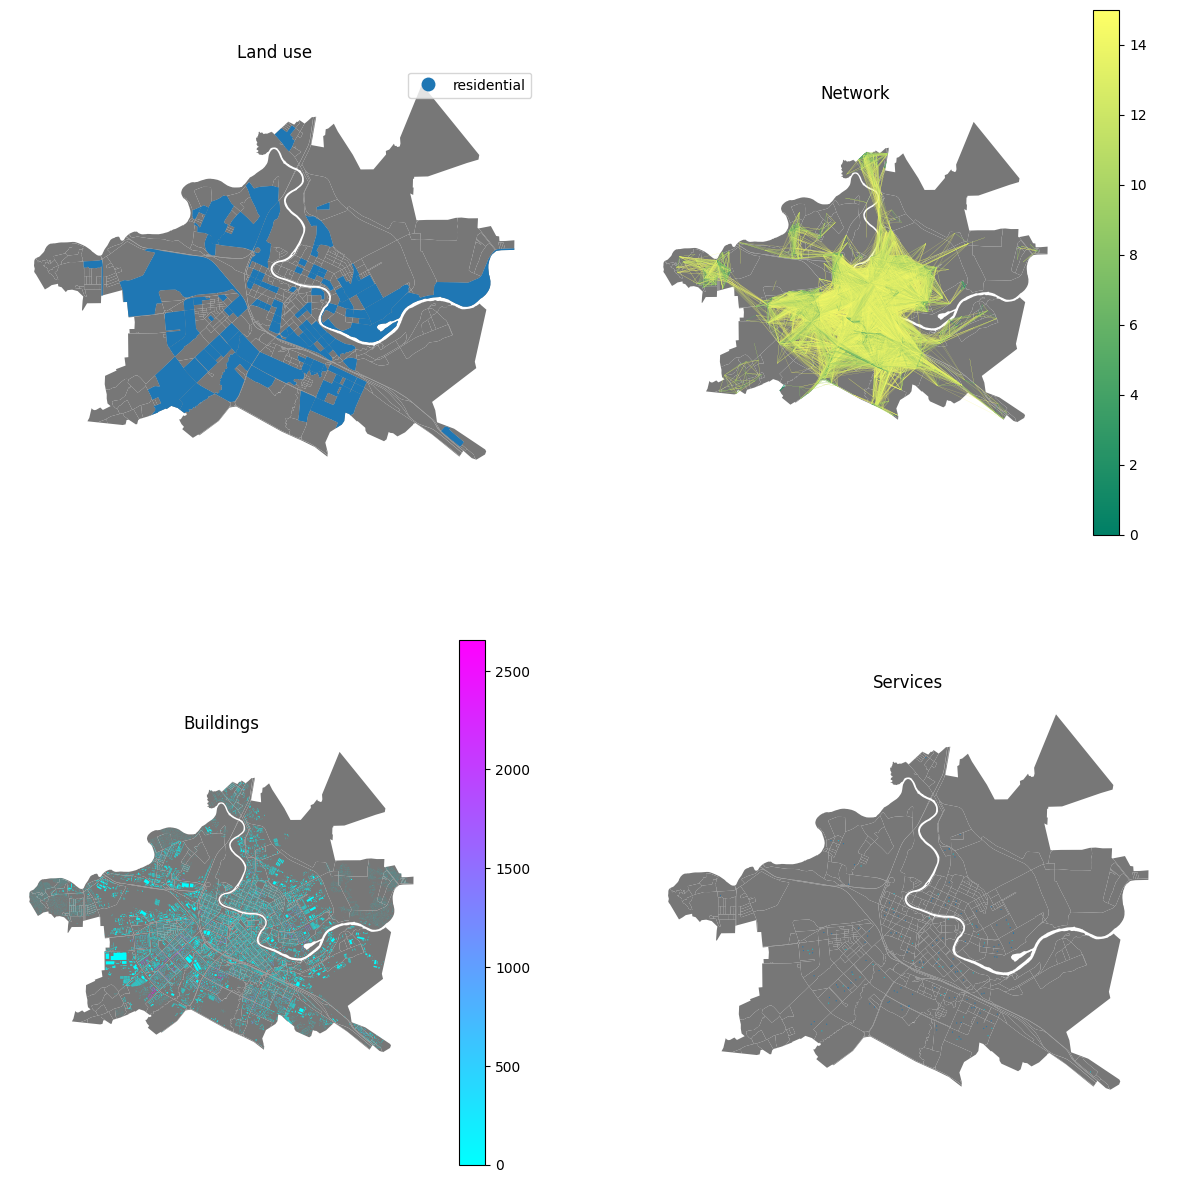

In [23]:
vologda.plot()

## 5. Methods for urban environment analysis

### 5.1. Accessibility

With the `Accessibility` class, you can get a layer with information about block accessibility (relative to the chosen block).

In [24]:
import random

block = random.choice(vologda.blocks)

In [25]:
from blocksnet.method import Accessibility

acc = Accessibility(city_model=vologda)
acc_res = acc.calculate(block)
acc_res.head()

,geometry,accessibility_to,accessibility_from
id,,,
0,"POLYGON ((550762.290 6565038.844, 550768.857 6...",47.15625,47.62500
1,"POLYGON ((550768.857 6565033.563, 550762.290 6...",48.93750,49.15625
2,"POLYGON ((544937.479 6564706.592, 544935.619 6...",92.31250,87.18750
3,"POLYGON ((544806.647 6565359.291, 544814.358 6...",78.18750,80.93750
4,"POLYGON ((544793.346 6565395.228, 544800.150 6...",72.87500,75.62500


Visualizing the resulting accessibility `GeoDataFrame`.

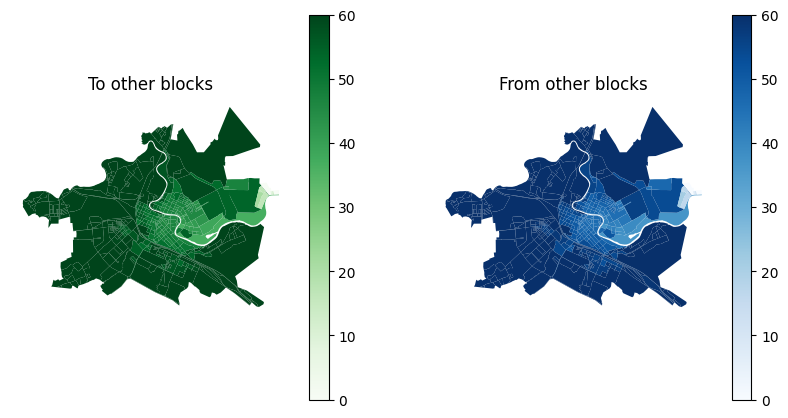

In [26]:
acc.plot(acc_res, figsize=(10,5))

You can also filter blocks that can potentially supply the chosen block with services of certain type.

In [27]:
service_type = vologda['school']
accessibility = service_type.accessibility
accessibility

15

In [28]:
acc_res_st = acc_res[acc_res['accessibility_to']<=accessibility]
acc_res_st

,geometry,accessibility_to,accessibility_from
id,,,
491,"POLYGON ((557733.822 6566501.805, 557716.377 6...",0.000000,0.000000
673,"POLYGON ((557929.513 6566532.311, 557868.701 6...",9.039062,9.039062
674,"POLYGON ((557988.145 6566536.245, 557929.513 6...",9.718750,9.718750


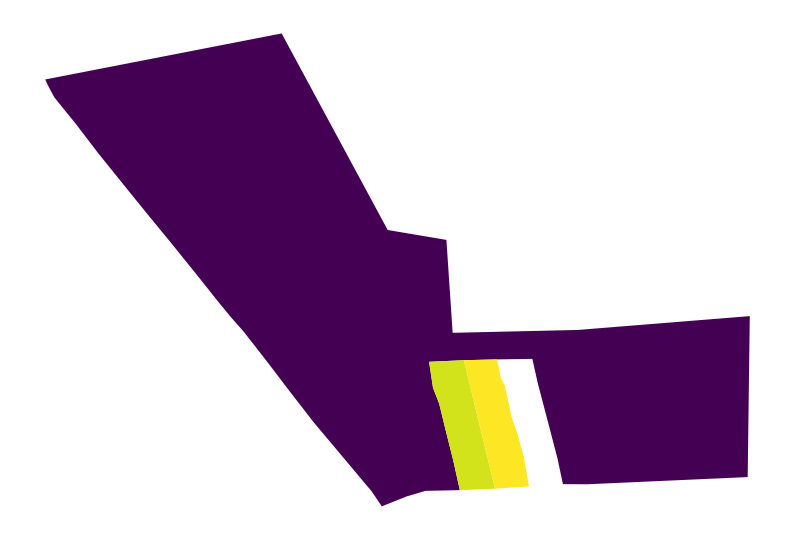

In [29]:
acc_res_st.plot(figsize=(10,10), column='accessibility_to').set_axis_off()

Saving the results to a `geojson` file

In [30]:
acc_res.to_file('accessibility.geojson')

### 5.2. Connectivity

Other methods are used in a similar way. Here is an example of blocks' **transport connectivity** calculation using `Connectivity` class.

In [31]:
from blocksnet import Connectivity

con = Connectivity(city_model=vologda)
con_res = con.calculate()

Visualizating the connectivity result.

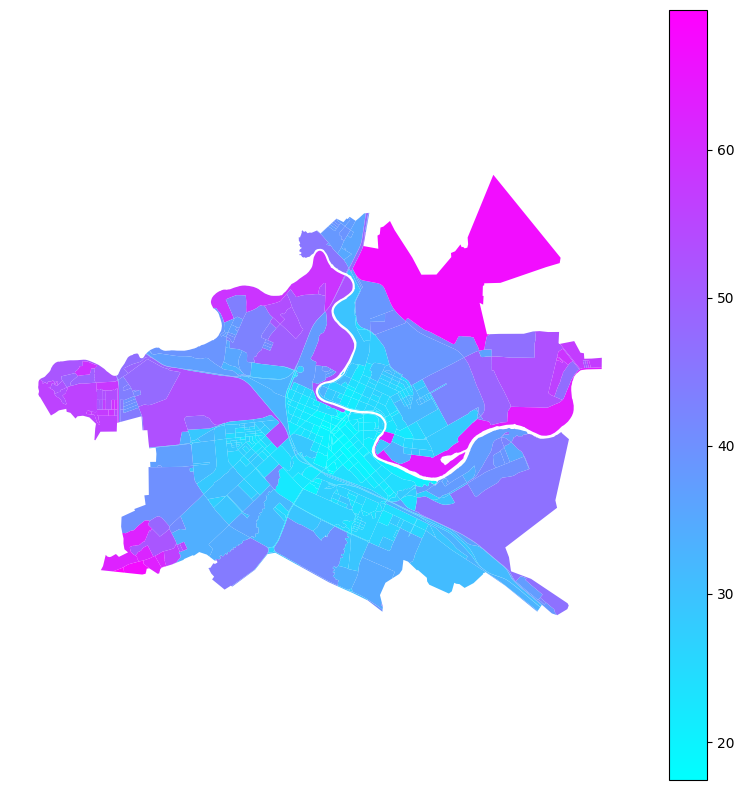

In [32]:
con.plot(con_res)

### 5.3. Service Provision

You can also assess service type provision for any block. Normative capacity and block population are used in assessment.

In [33]:
from blocksnet import Provision, ProvisionMethod

prov = Provision(city_model=vologda)
prov_res = prov.calculate(service_type)

2024-09-25 18:48:35.670 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 15 : 192x37
2024-09-25 18:48:35.780 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-09-25 18:48:35.835 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-09-25 18:48:35.937 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 30 : 52x18
2024-09-25 18:48:35.967 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-09-25 18:48:35.988 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-09-25 18:48:36.022 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 60 : 26x4
2024-09-25 18:48:36.028 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-09-25 18:48:36.039 | INFO     | blocksne

Visualization of service provision.

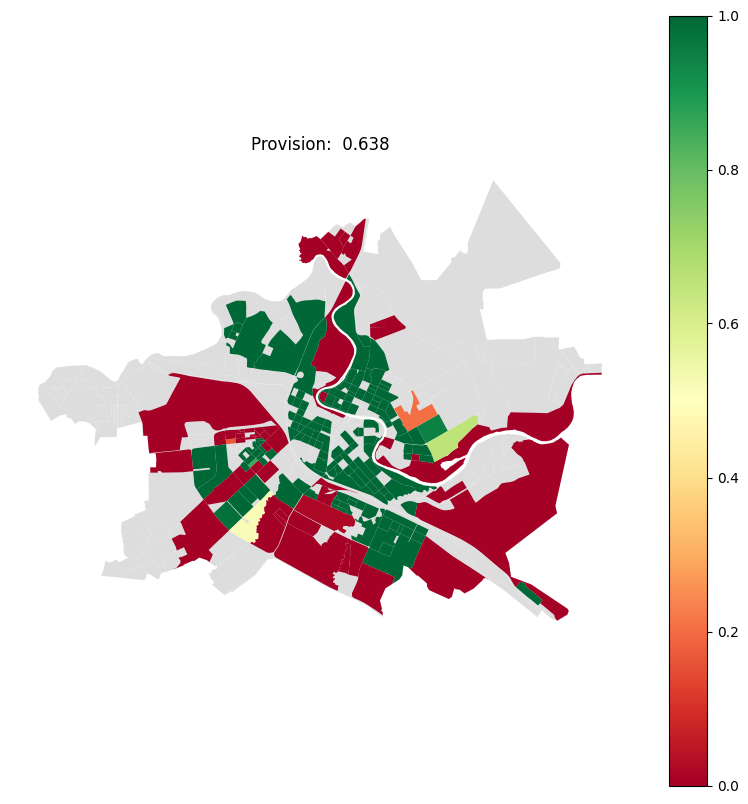

In [34]:
prov.plot(prov_res)

Save result to a file.

In [35]:
prov_res.to_file('provision_gravity.geojson')

You can also use iterative greedy method of population distribution for provision assessment.

In [36]:
prov_res_gr = prov.calculate(service_type, method=ProvisionMethod.GREEDY)

2024-09-25 18:49:14.785 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


Visualizating the result.

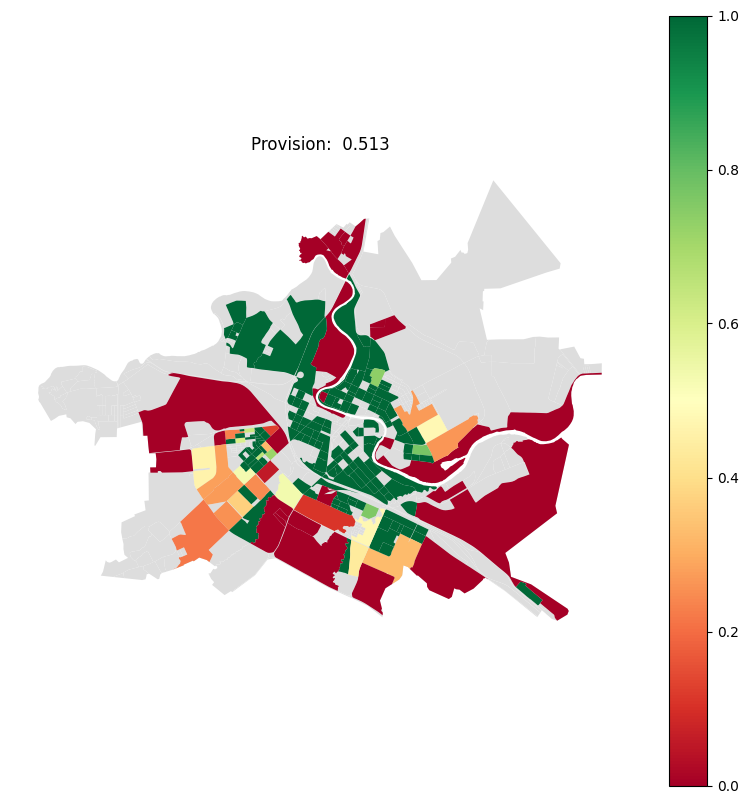

In [37]:
prov.plot(prov_res_gr)

Getting statistical parameters of provision.

In [38]:
Provision.stat(prov_res_gr)

{'mean': 0.8027122468957005, 'median': 1.0, 'min': 0.0, 'max': 1.0}

Getting city-wide provision estimate.

In [39]:
Provision.total(prov_res_gr)

0.5132829977628636

Saving results to a file.

In [40]:
prov_res_gr.to_file('provision_greedy.geojson')

You can modify parameters of any block and perform provision assessment again. 
Let's take a block with **id=110** and increase its population by 1000 people.

In [41]:
import pandas as pd
update = {
  110: {
    'population': 1000,
  }
}
update_df = pd.DataFrame.from_dict(update, orient='index')

In [42]:
prov_res_after = prov.calculate(service_type, update_df)

2024-09-25 18:49:16.556 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 15 : 193x37
2024-09-25 18:49:16.662 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-09-25 18:49:16.701 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-09-25 18:49:16.820 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 30 : 53x18
2024-09-25 18:49:16.853 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-09-25 18:49:16.876 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-09-25 18:49:16.910 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 60 : 27x4
2024-09-25 18:49:16.917 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-09-25 18:49:16.929 | INFO     | blocksne

Visualization of provision after modification of block parameters.

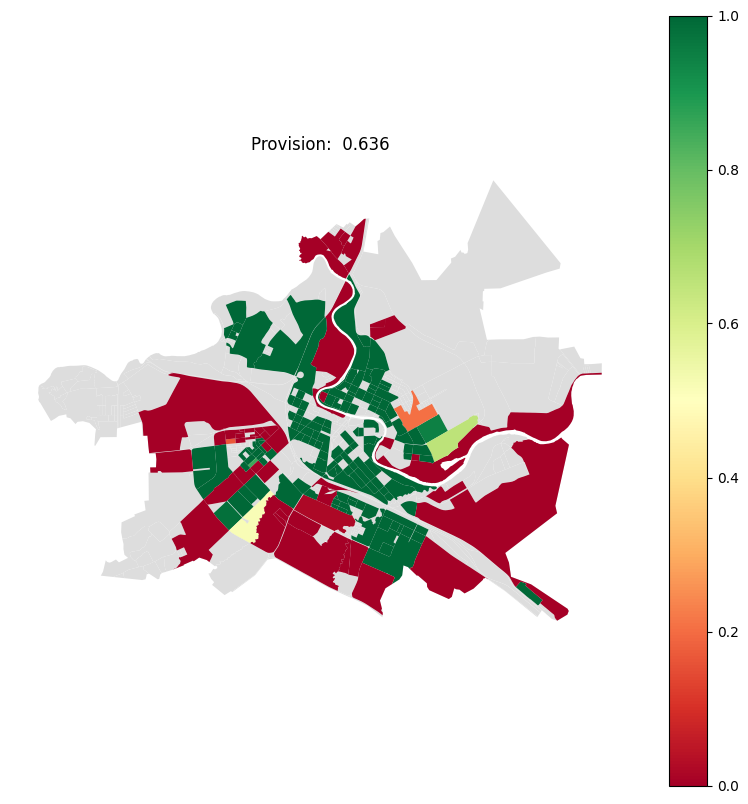

In [43]:
prov.plot(prov_res_after)

Saving the results as a ```geojson``` file.

In [44]:
prov_res_after.to_file('provision_update.geojson')

### 5.4. Services composition optimization

Selecting the scenario (concept) of city development includes specifiying weights for each of the service types.

In [45]:
scenario = {
    'school': 0.6,
    'kindergarten': 0.4
}

In [46]:
blocks = vologda.get_blocks_gdf(simplify=True)
blocks.head()

,geometry,land_use,is_living,build_floor_area,living_demand,living_area,share_living,business_area,share_business,site_area,population,footprint_area,fsi,gsi,l,osr,mxi
id,,,,,,,,,,,,,,,,,
0,"POLYGON ((550762.290 6565038.844, 550768.857 6...",None,False,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.050029e+03,0,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,"POLYGON ((550768.857 6565033.563, 550762.290 6...",None,False,0.000000,NaN,0.000000,NaN,0.000000,NaN,3.423072e+03,0,0.000000,0.000000,0.000000,NaN,NaN,NaN
2,"POLYGON ((544937.479 6564706.592, 544935.619 6...",residential,True,541366.098806,22.056246,94819.799728,0.221511,446546.299077,1.043187,5.013304e+06,4299,428059.648861,0.107986,0.085385,1.264698,8.469765,0.175149
3,"POLYGON ((544806.647 6565359.291, 544814.358 6...",None,False,3599.332605,NaN,0.000000,0.000000,3599.332605,1.000000,1.706084e+05,0,3599.332605,0.021097,0.021097,1.000000,46.400012,0.000000
4,"POLYGON ((544793.346 6565395.228, 544800.150 6...",None,False,3204.576494,NaN,0.000000,0.000000,3204.576494,1.000000,4.019534e+04,0,3204.576494,0.079725,0.079725,1.000000,11.543104,0.000000


In [47]:
from blocksnet import LandUse

blocks_fsi = blocks.fsi
blocks_gsi = blocks.gsi
blocks_lu = blocks.apply(lambda s : (LandUse.RESIDENTIAL if s.is_living else LandUse.RECREATION) if s.land_use is None else s.land_use, axis=1).apply(LandUse).to_dict()

In [48]:
from blocksnet import AnnealingOptimizer

ao = AnnealingOptimizer(city_model=vologda)
X, indicators, value, provisions = ao.calculate(blocks_lu, blocks_fsi, blocks_gsi, scenario)

Value : 0.815:  55%|█████▌    | 550/1000 [02:10<01:47,  4.20it/s]


As you can see, the method have "placed" some services as if we didn't have any services already to increase the provision.

In [49]:
provisions

{'school': 0.8472210572229025, 'kindergarten': 0.7675453047775948}

Visualizing possible school capacities

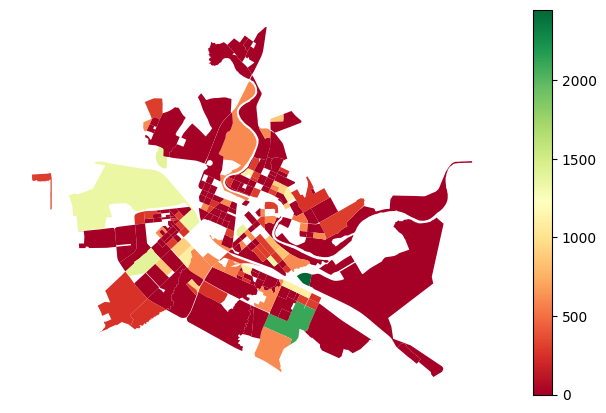

In [50]:
ao.to_gdf(X, indicators).plot(column='school', cmap='RdYlGn', figsize=(10,5), legend=True).set_axis_off()

Output of the exact requirements:

In [51]:
ao.to_bricks_df(X)

,block_id,service_type,is_integrated,area,capacity,count
0,2,school,False,3200.0,250,1
3,2,school,False,13000.0,1100,1
24,13,kindergarten,True,320.0,180,1
27,19,school,False,4000.0,300,1
29,19,school,False,13000.0,1100,1
...,...,...,...,...,...,...
2585,590,kindergarten,True,320.0,180,1
2629,623,school,False,13000.0,1100,2
2630,623,school,True,2200.0,250,1
2637,623,kindergarten,True,320.0,180,1


To calculate and visualize the provision one must make an `update_df` again. At first, get `clear_df`, that "removes" everything from the city for the `Provision`.

In [52]:
clear_df = ao._get_clear_df(vologda._blocks.keys())
clear_df.head()

,population,kindergarten,school,hospital,polyclinic,pitch,swimming_pool,stadium,theatre,museum,...,bus_station,bus_stop,pier,animal_shelter,military_kom,prison,landfill,plant_nursery,greenhouse_complex,warehouse
id,,,,,,,,,,,,,,,,,,,,,
0,0,-0.0,-0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,-0.0,-0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-4299,-640.0,-0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,-0.0,-0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,-0.0,-0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Get the `df` with values obtained by the optimizer.

In [53]:
df = ao.to_df(X, indicators)
df.head()

,population,school,kindergarten
block_id,,,
2,5665,1350.0,0.0
13,1160,0.0,180.0
19,1482,1400.0,320.0
23,587,300.0,320.0
32,3934,0.0,80.0


Sum everything to get the actual state.

In [54]:
clear_df['population'] += df['population']
clear_df['school'] += df['school']
clear_df['kindergarten'] += df['kindergarten']

In [55]:
prov_ann = prov.calculate('school', clear_df)

2024-09-25 18:51:31.002 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 15 : 203x104
2024-09-25 18:51:31.313 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-09-25 18:51:31.400 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-09-25 18:51:31.567 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 30 : 26x51
2024-09-25 18:51:31.602 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-09-25 18:51:31.624 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-09-25 18:51:31.652 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 60 : 2x42
2024-09-25 18:51:31.657 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-09-25 18:51:31.666 | INFO     | blocksn

In [56]:
prov_ann.head()

,geometry,demand,capacity,capacity_left,demand_left,demand_within,demand_without,provision
id,,,,,,,,
0,"POLYGON ((550762.290 6565038.844, 550768.857 6...",0,0.0,0.0,0,0,0,NaN
1,"POLYGON ((550768.857 6565033.563, 550762.290 6...",0,0.0,0.0,0,0,0,NaN
2,"POLYGON ((544937.479 6564706.592, 544935.619 6...",680,1350.0,670.0,0,680,0,1.0
3,"POLYGON ((544806.647 6565359.291, 544814.358 6...",0,0.0,0.0,0,0,0,NaN
4,"POLYGON ((544793.346 6565395.228, 544800.150 6...",0,0.0,0.0,0,0,0,NaN


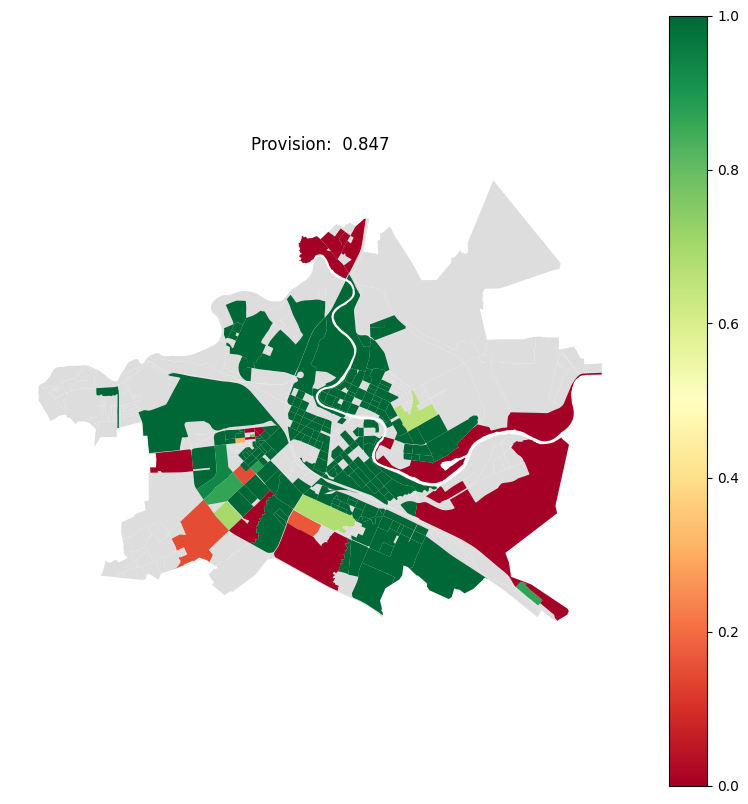

In [57]:
prov.plot(prov_ann)